# Lung Cancer Detection using Convolutional Neural Network (CNN)

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


## Importing Dataset

In [ ]:
# download from kaggle cat and dog : 
# https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
# As a .zip file

In [4]:
data_path = 'lung-and-colon-cancer-histopathological-images.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')


The data set has been extracted.


## Data Visualization

In [7]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

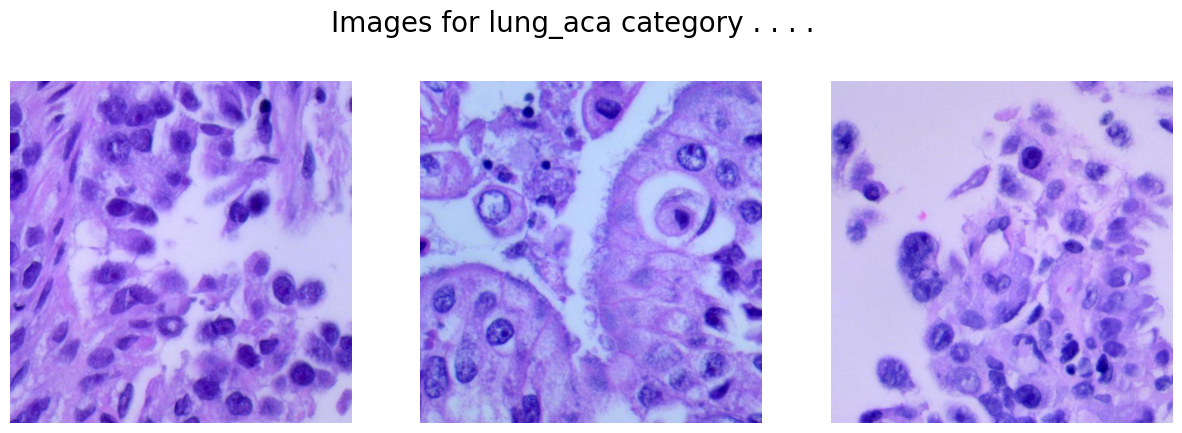

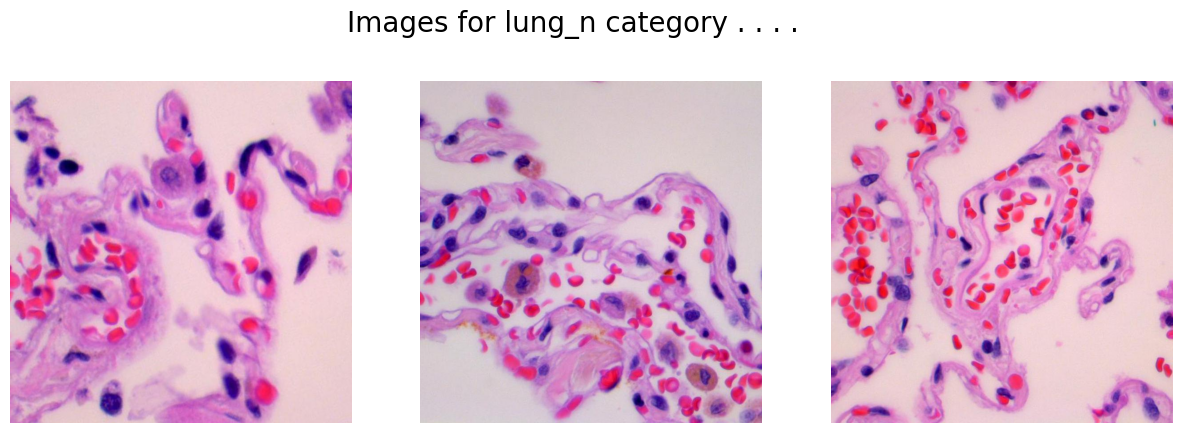

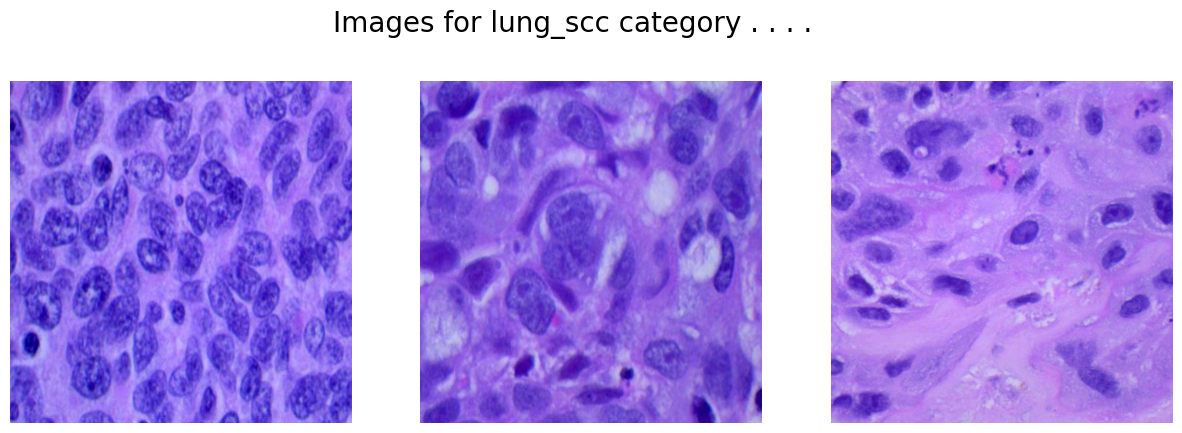

In [9]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


## Data Preparation for Training

In [11]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)


In [12]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

## Model Compilation

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


## Callback

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

checkpointCNN = ModelCheckpoint("best_lung_cancer_detection_CNN", monitor='val_loss', verbose=1, save_best_only=True, mode='min')


## Model Training

In [16]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback(), checkpointCNN])


Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8452
Epoch 1: val_loss improved from inf to 28.69999, saving model to best_lung_cancer_detection_CNN
INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


188/188 [==============================] - 279s 1s/step - loss: 0.3721 - accuracy: 0.8452 - val_loss: 28.7000 - val_accuracy: 0.3257 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9075
Epoch 2: val_loss improved from 28.69999 to 6.92033, saving model to best_lung_cancer_detection_CNN
INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


188/188 [==============================] - 268s 1s/step - loss: 0.2285 - accuracy: 0.9075 - val_loss: 6.9203 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9364
Epoch 3: val_loss improved from 6.92033 to 2.68129, saving model to best_lung_cancer_detection_CNN
INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


188/188 [==============================] - 283s 2s/step - loss: 0.1675 - accuracy: 0.9364 - val_loss: 2.6813 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9457
Epoch 4: val_loss did not improve from 2.68129
188/188 [==============================] - 282s 1s/step - loss: 0.1384 - accuracy: 0.9457 - val_loss: 2.7929 - val_accuracy: 0.6517 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9584
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 2.68129
188/188 [==============================] - 287s 2s/step - loss: 0.1057 - accuracy: 0.9584 - val_loss: 6.5431 - val_accuracy: 0.3343 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9793
Epoch 6: val_loss improved from 2.68129 to 1.21306, saving model to best_lung_cancer_detection_CNN
INFO:te

INFO:tensorflow:Assets written to: best_lung_cancer_detection_CNN\assets


188/188 [==============================] - 284s 2s/step - loss: 0.0626 - accuracy: 0.9793 - val_loss: 1.2131 - val_accuracy: 0.6957 - lr: 5.0000e-04
Epoch 7/10
188/188 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9847
Epoch 7: val_loss did not improve from 1.21306
188/188 [==============================] - 289s 2s/step - loss: 0.0444 - accuracy: 0.9847 - val_loss: 1.7695 - val_accuracy: 0.7137 - lr: 5.0000e-04
Epoch 8/10
188/188 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9863
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: val_loss did not improve from 1.21306
188/188 [==============================] - 284s 2s/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 2.6042 - val_accuracy: 0.5383 - lr: 5.0000e-04
Epoch 9/10
188/188 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9915
Epoch 9: val_loss did not improve from 1.21306
188/188 [==============================] - 285s

## Visualizing

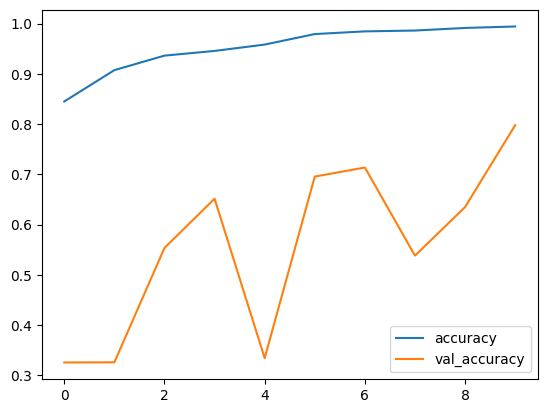

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


## Model Evaluation

In [18]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))


94/94 [==============================] - 11s 118ms/step
              precision    recall  f1-score   support

    lung_aca       0.91      0.43      0.58       987
      lung_n       0.95      0.97      0.96       977
    lung_scc       0.66      0.99      0.79      1036

    accuracy                           0.80      3000
   macro avg       0.84      0.80      0.78      3000
weighted avg       0.84      0.80      0.78      3000



In [19]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.91      0.43      0.58       987
      lung_n       0.95      0.97      0.96       977
    lung_scc       0.66      0.99      0.79      1036

    accuracy                           0.80      3000
   macro avg       0.84      0.80      0.78      3000
weighted avg       0.84      0.80      0.78      3000

